In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload

import tree_utils
reload(tree_utils)
from tree_utils import *


In [2]:
data_raw = pd.read_csv("aps_failure_training_set.csv", skiprows = 20)

# Try to understand data
data_raw.shape
data_raw.head()

data_raw_small  = data_raw.iloc[0:10000,:]

#data_raw_small.apply(pd.value_counts)["na"]

from clean_data1 import clean_data
X, Y = clean_data(data_raw_small)

Y.value_counts(normalize=True)

# Y = Y.apply(lambda x: 1 if x =="neg" else 0)
Y.head()


/home/malcolm/Documents/aps_failure/clean_data1.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_raw.drop(large_pct_na, axis = 1, inplace= True)


Beginning to drop na's and nan's... this may take a while 
Finished replacing....
Shape before: (10000, 143)
Shape after: (10000, 142)


0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25, random_state = 1)

compare_samples = pd.DataFrame({"Train":y_train.value_counts(normalize=True),
"Test": y_test.value_counts(normalize=True),
"Full":Y.value_counts(normalize=True)})

compare_samples

,Full,Test,Train
1,0.9805,0.9824,0.979867
0,0.0195,0.0176,0.020133


### Begin Random Forest Analysis 

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
rf_params = {"n_estimators" : 40, "max_depth":4, "random_state":4, "class_weight":{1:10, 0:500}}

estimator = RandomForestClassifier(**rf_params)
estimator.fit(X_train, y_train)

estimator.score(X_train, y_train)
preds1 = estimator.predict(X_train)

custom_score_aps(y_train, preds1)

          Pred_0  Pred_1
Actual_0     148       3
Actual_1     267    7082


0.556

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     105    2351


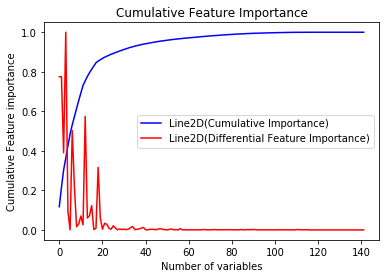

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     105    2351


1.22

In [6]:
preds_test = estimator.predict(X_test)
custom_score_aps(y_test, preds_test)

len(estimator.feature_importances_)

# Feature importance stuff
feat_imp = pd.DataFrame(estimator.feature_importances_, index = X_train.columns, columns = ["Feat_Importance"])

feat_imp2 = get_cum_feat_imp(feat_imp)
plot_cum_feat_imp(feat_imp2)
custom_score_aps(y_test, preds_test)


In [7]:
cum_cutoff = 0.90
indiv_cutoff = 0.002
high_imp_feats1 = feat_imp2[feat_imp2["Cum_Imp"] < cum_cutoff]
print(len(high_imp_feats1))
high_imp_feats2 = feat_imp[feat_imp["Feat_Importance"] > indiv_cutoff]
print(len(high_imp_feats2))
high_imp_feats2.head()
# high_imp_feats1.to_csv("High_Importance_27vars.csv", index = False)
# high_imp_feats2.to_csv("High_Importance_43vars.csv", index = False)

27
43


,Feat_Importance
aa_000,0.117367
ag_002,0.002832
ag_003,0.008399
ag_004,0.006861
ah_000,0.062258


## Let's build a smaller Random Forest

In [8]:
X_train_small = X_train[high_imp_feats2.index]
X_test_small = X_test[high_imp_feats2.index]

In [9]:
small_est = RandomForestClassifier(**rf_params)
small_est.fit(X_train_small, y_train)

small_est.score(X_train_small, y_train)
preds2 = small_est.predict(X_train_small)

custom_score_aps(y_train, preds2)


          Pred_0  Pred_1
Actual_0     148       3
Actual_1     253    7096


0.5373333333333333

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     106    2350


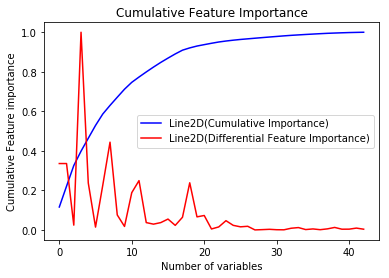

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     106    2350


1.224

In [10]:
preds_test2 = small_est.predict(X_test_small)
custom_score_aps(y_test, preds_test2)

len(estimator.feature_importances_)

# Feature importance stuff
feat_imp_small = pd.DataFrame(small_est.feature_importances_, index = X_train_small.columns, columns = ["Feat_Importance"])

feat_imp_small2 = get_cum_feat_imp(feat_imp_small)
plot_cum_feat_imp(feat_imp_small2)
custom_score_aps(y_test, preds_test2)


### Begin examining correlations 

In [11]:
corr_df_raw = pd.concat([X_train_small, y_train], axis = 1)

In [12]:
corr_df_raw.shape

(7500, 44)

In [13]:
corr_df_raw.head()

,aa_000,ag_002,ag_003,ag_004,ah_000,al_000,am_0,ao_000,ap_000,aq_000,...,cs_002,cs_003,cs_004,cs_006,de_000,dn_000,dt_000,ee_000,ee_001,class
651,10,0,0,96,1580,0,0,17758,12208,470,...,18,10,180,1240,100,166,16,2976,1356,1
6560,409078,0,0,49444,13926286,660374,1198326,17536714,9891218,5651258,...,898036,174704,1096546,402,78,369890,12116,951194,530612,0
8974,91842,0,26116,586288,2955026,9966,14856,4528178,815134,439354,...,263454,347792,229642,1534732,106,41594,44760,758946,793972,1
2348,39896,0,0,115690,1139312,258,512,2130364,595560,145176,...,153534,129636,235872,136718,376,12458,7032,488442,247256,1
5670,98196,0,2258,184106,3254412,5400,8126,5347704,933460,398896,...,304416,398720,393604,681178,102,41540,44460,694408,1298672,1


In [14]:
corr = corr_df_raw.applymap(np.float64).corr()

In [15]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


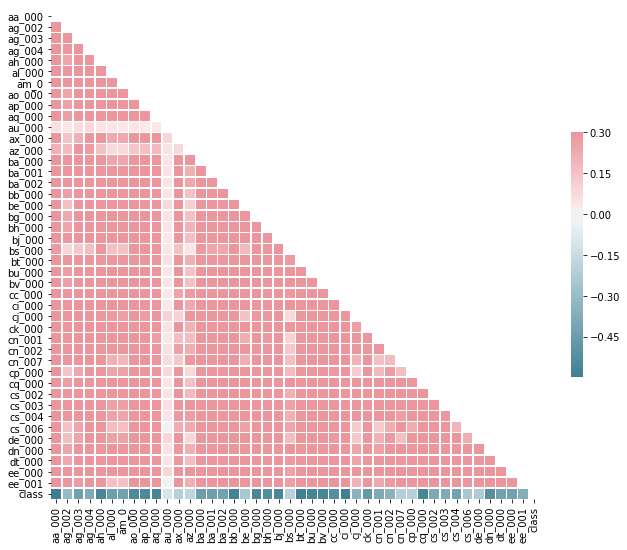

In [16]:
plt.show()

In [17]:
corr["class"]

aa_000   -0.597615
ag_002   -0.308480
ag_003   -0.432553
ag_004   -0.381792
ah_000   -0.561489
al_000   -0.444962
am_0     -0.429586
ao_000   -0.552920
ap_000   -0.545780
aq_000   -0.570137
au_000   -0.105877
ax_000   -0.207901
az_000   -0.177001
ba_000   -0.447897
ba_001   -0.438734
ba_002   -0.426786
bb_000   -0.573661
be_000   -0.248461
bg_000   -0.557961
bh_000   -0.528486
bj_000   -0.562229
bs_000   -0.198826
bt_000   -0.590391
bu_000   -0.568838
bv_000   -0.568838
cc_000   -0.523180
ci_000   -0.595626
cj_000   -0.351247
ck_000   -0.465113
cn_001   -0.382298
cn_002   -0.349071
cn_007   -0.211151
cp_000   -0.212898
cq_000   -0.568838
cs_002   -0.391677
cs_003   -0.383735
cs_004   -0.425193
cs_006   -0.247903
de_000   -0.227309
dn_000   -0.518883
dt_000   -0.425018
ee_000   -0.427670
ee_001   -0.365178
class     1.000000
Name: class, dtype: float64

In [18]:
feat_imp_small2.head()

,Feat_Importance,Cum_Imp,Diff_Feat_Imp
ck_000,0.115872,0.115872,0.335787
ci_000,0.105243,0.221115,0.335787
bu_000,0.104472,0.325587,0.024198
dn_000,0.072832,0.398419,1.000000
bt_000,0.065317,0.463736,0.237381


In [19]:
feats_corr = feat_imp_small2.join(corr["class"])

In [20]:
feats_corr.sort_values(by="class").head(7)

,Feat_Importance,Cum_Imp,Diff_Feat_Imp,class
aa_000,0.041254,0.671203,0.075613,-0.597615
ci_000,0.105243,0.221115,0.335787,-0.595626
bt_000,0.065317,0.463736,0.237381,-0.590391
bb_000,0.021806,0.869180,0.054858,-0.573661
aq_000,0.002253,0.986552,0.011830,-0.570137
bv_000,0.025653,0.799102,0.037016,-0.568838
bu_000,0.104472,0.325587,0.024198,-0.568838


In [21]:
feats_corr.sort_values(by="class").tail(7)

,Feat_Importance,Cum_Imp,Diff_Feat_Imp,class
de_000,0.006924,0.944182,0.004792,-0.227309
cp_000,0.006441,0.950623,0.015072,-0.212898
cn_007,0.002971,0.975823,0.003073,-0.211151
ax_000,0.002025,0.990767,0.005015,-0.207901
bs_000,0.000858,0.999262,0.009205,-0.198826
az_000,0.002634,0.984299,0.008496,-0.177001
au_000,0.001809,0.994558,0.005286,-0.105877


In [22]:
feats_corr.sort_values(by="Feat_Importance").head(7)

,Feat_Importance,Cum_Imp,Diff_Feat_Imp,class
ee_001,0.000738,1.000000,0.003607,-0.365178
bs_000,0.000858,0.999262,0.009205,-0.198826
be_000,0.001156,0.998403,0.003861,-0.248461
ba_002,0.001284,0.997247,0.003623,-0.426786
cs_006,0.001405,0.995963,0.012549,-0.247903
au_000,0.001809,0.994558,0.005286,-0.105877
cj_000,0.001982,0.992749,0.001161,-0.351247


### Begin exploring Predictions before LIME

In [23]:
preds_prob_test_raw = small_est.predict_proba(X_test_small)
preds_prob_test = [x[0] for x in preds_prob_test_raw]

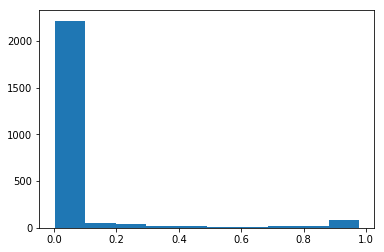

In [24]:
plt.hist(preds_prob_test)
plt.show()

In [25]:
X_train2 = X_train_small.applymap(float)


In [30]:
pred_quantiles = pd.Series(preds_prob_test).quantile(np.arange(0.01, 0.99, 0.1))
pred_quantiles

0.01    0.002022
0.11    0.002022
0.21    0.002022
0.31    0.002022
0.41    0.002022
0.51    0.002798
0.61    0.007186
0.71    0.010763
0.81    0.032614
0.91    0.210931
dtype: float64

We see that around 50% of the scores have a score around 0.002 or 0.2%  
The highest tile of scores are at 0.21

In [31]:
def segment_score_vals(h_cutoff, l_cutoff):
    segment = [(score, indep_vars) for score, indep_vars in zip(preds_prob_test, X_train2.values) if score > l_cutoff and score < h_cutoff]
    print("List has number of elements: ", len(segment))
    return(segment)


In [32]:
def segment_score(h_cutoff, l_cutoff):
    segment = [(score, indep_vars) for score, indep_vars in zip(preds_prob_test, X_train2.iterrows()) if score > l_cutoff and score < h_cutoff]
    print("List has number of elements: ", len(segment))
    return(segment)


In [33]:
high_score = segment_score_vals(1, 0.03)
low_score = segment_score_vals(0.0023, 0.0)

List has number of elements:  492
List has number of elements:  1190


In [34]:
low_score[1][1]

array([2.44000000e+04, 0.00000000e+00, 0.00000000e+00, 3.68200000e+03,
       9.05016000e+05, 0.00000000e+00, 0.00000000e+00, 1.52328400e+06,
       3.25622000e+05, 1.28146000e+05, 0.00000000e+00, 0.00000000e+00,
       1.57600000e+03, 8.11662000e+05, 4.32456000e+05, 1.69754000e+05,
       2.03077800e+06, 6.04000000e+02, 9.05016000e+05, 2.52220000e+04,
       1.55540000e+05, 1.23040000e+05, 2.44003500e+04, 2.03077800e+06,
       2.03077800e+06, 1.86428000e+06, 1.57623744e+06, 0.00000000e+00,
       2.84745600e+05, 0.00000000e+00, 0.00000000e+00, 1.18680000e+04,
       0.00000000e+00, 2.03077800e+06, 2.53200000e+03, 2.07750000e+05,
       1.57542000e+05, 5.48556000e+05, 1.66000000e+02, 1.26180000e+04,
       1.06720000e+04, 3.08408000e+05, 4.92498000e+05])

### Begin Using LIME 

In [35]:
import lime
import lime.lime_tabular

In [36]:
high_data = np.array([x[1] for x in high_score])
low_data = np.array([x[1] for x in low_score])


In [162]:
# Remember that lime explainer needs values as float 
explainer_low = lime.lime_tabular.LimeTabularExplainer(high_data, feature_names = X_train2.columns, \
                                                      discretize_continuous= False)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train2.values, \
                                                   feature_names = X_train2.columns,\
                                                   class_names = y_train.unique(), discretize_continuous= False)


In [161]:
exp2 = explainer_low.explain_instance(high_data[0], small_est.predict_proba, num_features=5, num_samples=1000)
exp3 = explainer_low.explain_instance(low_data[0], small_est.predict_proba, num_features = 5, num_samples = 1000)


In [49]:
exp2.as_list()


[('av_000', -0.033990685156725244),
 ('ac_000', -0.023314414215452234),
 ('aa_000', -0.015267862610420147),
 ('as_000', -0.01436716571857826),
 ('az_000', -0.014026109901449535)]

In [50]:
exp3.as_list()


[('av_000', -0.03116878568882668),
 ('aa_000', -0.023696629212385405),
 ('as_000', -0.0204131827312171),
 ('at_000', -0.020151890741195926),
 ('ac_000', -0.016723367585050344)]

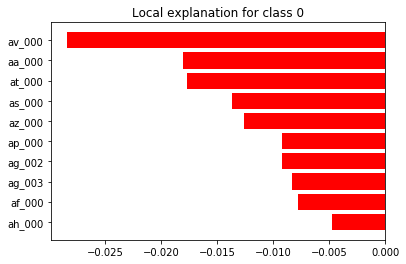

In [51]:
exp = explainer.explain_instance(low_data[0], small_est.predict_proba, num_features=10, num_samples = 2000)
exp.as_pyplot_figure()

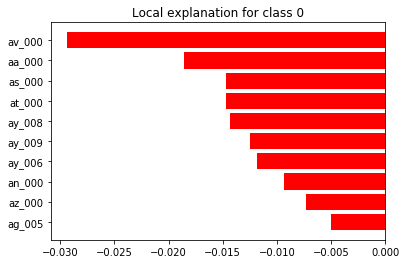

In [52]:
exp = explainer.explain_instance(high_data[0], small_est.predict_proba, num_features=10, num_samples = 2000)
exp.as_pyplot_figure()

In [163]:
# Get explainations for an instance 

def get_top_feats(row): 
    """
    Returns feature name and normalized coefficient from explainer "explain instance" 
    Note this function assumes that there are parameters already defined 
        small_est = estimator that can predict probabilities 
        explainer = lime estimator 
    """
    exp1 = explainer.explain_instance(row, small_est.predict_proba, num_features=5, num_samples=500)
    feat_list = exp1.as_list()
    get_name = lambda y: y[0].split()[0]
    feats = [(get_name(x), x[1]) for x in feat_list]
    
    return(feats)


In [164]:
print("Number of low scores: ", len(low_score))
print("Number of high scores: ", len(high_score))

Number of low scores:  1190
Number of high scores:  492


In [165]:
n_obs = 50
# Loop through h and l scores and get the top explainer features 
low_score_feats = [get_top_feats(x[1]) for x in low_score[:n_obs]]
print("Finished low scores")
high_score_feats = [get_top_feats(x[1]) for x in high_score[:n_obs]]

Finished low scores


In [166]:
# Concatenate each explaination score into one dataframe 
master_df_low = pd.DataFrame()
for exp in low_score_feats:
    temp_df = pd.DataFrame(exp)
    master_df_low = pd.concat([master_df_low, temp_df], axis = 0)
master_df_low.columns = ["Feature",  "Coefficient"]
print("Master df low shape: ", master_df_low.shape)

Master df low shape:  (250, 2)


In [167]:
master_df_high = pd.DataFrame()
for exp in high_score_feats:
    temp_df = pd.DataFrame(exp)
    master_df_high = pd.concat([master_df_high, temp_df], axis = 0)
master_df_high.columns = ["Feature",  "Coefficient"]
print("Master df high shape: ", master_df_high.shape)

Master df high shape:  (250, 2)


In [168]:
low_feat_coef_gb = master_df_low.groupby("Feature")
cnt_mean_low = low_feat_coef_gb.apply(lambda x: (np.mean(x)[0], len(x)))
low_feat_coef_gb.describe()


Coefficient                                                      \
              count          mean       std           min           25%   
Feature                                                                   
aa_000         38.0 -1.756645e-02  0.002417 -2.458508e-02 -1.843870e-02   
ag_002         16.0 -1.575354e-02  0.001772 -1.933282e-02 -1.699251e-02   
am_0            4.0 -1.435154e-02  0.001558 -1.609280e-02 -1.509804e-02   
ao_000          1.0 -1.038629e-02       NaN -1.038629e-02 -1.038629e-02   
ap_000          4.0 -1.485756e-02  0.001451 -1.676350e-02 -1.559007e-02   
aq_000          2.0 -1.582088e-02  0.001612 -1.696053e-02 -1.639071e-02   
ax_000          1.0 -1.237077e-02       NaN -1.237077e-02 -1.237077e-02   
ba_001          1.0 -1.397267e-02       NaN -1.397267e-02 -1.397267e-02   
bb_000          1.0 -1.846038e-06       NaN -1.846038e-06 -1.846038e-06   
bj_000          9.0 -1.515518e-02  0.003112 -2.026014e-02 -1.705800e-02   
bt_000          2.0 -1.552795e-02  0.001182 -1.636368e-02 -1.594581e-02   
bu_000          1.0 -1.310291e-02       NaN -1.310291e-02 -1.310291e-02   
cc_000         26.0 -1.649019e-02  0.002585 -2.156793e-02 -1.813900e-02   
ci_000         30.0 -1.730122e-02  0.003072 -2.621606e-02 -1.909439e-02   
cj_000          1.0 -1.246809e-02       NaN -1.246809e-02 -1.246809e-02   
ck_000         50.0 -2.828031e-02  0.005194 -3.678749e-02 -3.115327e-02   
cn_001          1.0 -1.142208e-07       NaN -1.142208e-07 -1.142208e-07   
cs_002          2.0 -1.456357e-02  0.001790 -1.582900e-02 -1.519628e-02   
cs_004         20.0 -1.423740e-02  0.003975 -1.963071e-02 -1.580647e-02   
de_000         20.0 -1.553811e-02  0.001761 -1.996371e-02 -1.651941e-02   
dn_000         14.0 -1.401155e-02  0.004128 -1.657271e-02 -1.564929e-02   
dt_000          4.0 -1.628457e-02  0.005158 -2.379230e-02 -1.724550e-02   
ee_000          2.0 -1.404632e-02  0.000804 -1.461489e-02 -1.433060e-02   

                                                   
                  50%           75%           max  
Feature                                            
aa_000  -1.721696e-02 -1.601576e-02 -1.348290e-02  
ag_002  -1.554948e-02 -1.438358e-02 -1.282784e-02  
am_0    -1.448767e-02 -1.374117e-02 -1.233800e-02  
ao_000  -1.038629e-02 -1.038629e-02 -1.038629e-02  
ap_000  -1.453608e-02 -1.380357e-02 -1.359457e-02  
aq_000  -1.582088e-02 -1.525105e-02 -1.468122e-02  
ax_000  -1.237077e-02 -1.237077e-02 -1.237077e-02  
ba_001  -1.397267e-02 -1.397267e-02 -1.397267e-02  
bb_000  -1.846038e-06 -1.846038e-06 -1.846038e-06  
bj_000  -1.447146e-02 -1.218914e-02 -1.186049e-02  
bt_000  -1.552795e-02 -1.511009e-02 -1.469222e-02  
bu_000  -1.310291e-02 -1.310291e-02 -1.310291e-02  
cc_000  -1.683820e-02 -1.489511e-02 -1.200844e-02  
ci_000  -1.702972e-02 -1.497791e-02 -1.191644e-02  
cj_000  -1.246809e-02 -1.246809e-02 -1.246809e-02  
ck_000  -2.883564e-02 -2.668747e-02 -1.993805e-06  
cn_001  -1.142208e-07 -1.142208e-07 -1.142208e-07  
cs_002  -1.456357e-02 -1.393085e-02 -1.329813e-02  
cs_004  -1.424032e-02 -1.322552e-02 -9.513921e-09  
de_000  -1.556371e-02 -1.413555e-02 -1.260576e-02  
dn_000  -1.502856e-02 -1.467563e-02 -2.231516e-06  
dt_000  -1.462799e-02 -1.366706e-02 -1.209000e-02  
ee_000  -1.404632e-02 -1.376203e-02 -1.347775e-02

In [169]:
# Gather metrics from each 
cnt_mean_low = master_df_low.groupby("Feature").apply(lambda x: pd.Series({"mean": np.mean(x)[0],
                                                                       "count":len(x), 
                                                                       "abs_mean":abs(np.mean(x)[0]), 
                                                                       "mean_sign":"pos" if np.mean(x)[0] > 0 else "neg" }))


In [170]:
cnt_mean_low.sort_values("count", ascending = False).head()


,abs_mean,count,mean,mean_sign
Feature,,,,
ck_000,0.028280,50,-0.028280,neg
aa_000,0.017566,38,-0.017566,neg
ci_000,0.017301,30,-0.017301,neg
cc_000,0.016490,26,-0.016490,neg
de_000,0.015538,20,-0.015538,neg


In [171]:
cnt_mean_low.sort_values("abs_mean", ascending = False).head()

,abs_mean,count,mean,mean_sign
Feature,,,,
ck_000,0.028280,50,-0.028280,neg
aa_000,0.017566,38,-0.017566,neg
ci_000,0.017301,30,-0.017301,neg
cc_000,0.016490,26,-0.016490,neg
dt_000,0.016285,4,-0.016285,neg


In [172]:
high_feat_coef_gb = master_df_high.groupby("Feature")
cnt_mean_high = high_feat_coef_gb.apply(lambda x: (np.mean(x)[0], len(x)))
high_feat_coef_gb.describe()
# Gather metrics from each feature group by 
cnt_mean_high = master_df_high.groupby("Feature").apply(lambda x: pd.Series({"mean": np.mean(x)[0],
                                                                       "count":len(x), 
                                                                       "abs_mean":abs(np.mean(x)[0]), 
                                                                       "mean_sign":"pos" if np.mean(x)[0] > 0 else "neg" }))



In [173]:
cnt_mean_high.sort_values("count", ascending = False).head()


,abs_mean,count,mean,mean_sign
Feature,,,,
ck_000,0.028443,50,-0.028443,neg
aa_000,0.017670,40,-0.017670,neg
ci_000,0.016071,31,-0.016071,neg
ag_002,0.015529,25,-0.015529,neg
cs_004,0.015538,25,-0.015538,neg


In [174]:
cnt_mean_high.sort_values("abs_mean", ascending = False).head()

,abs_mean,count,mean,mean_sign
Feature,,,,
ck_000,0.028443,50,-0.028443,neg
ax_000,0.019607,1,-0.019607,neg
aa_000,0.017670,40,-0.017670,neg
ba_001,0.016589,1,-0.016589,neg
ci_000,0.016071,31,-0.016071,neg


In [178]:
high_low_mean_cnt = cnt_mean_high.join(cnt_mean_low, how="outer", lsuffix="_high", rsuffix="_low")

In [181]:
high_low_mean_cnt["cnt_diff"] = high_low_mean_cnt["count_high"] - high_low_mean_cnt["count_low"]
high_low_mean_cnt["mean_diff"] = high_low_mean_cnt["mean_high"] - high_low_mean_cnt["mean_low"]

In [182]:
high_low_mean_cnt.head()

,abs_mean_high,count_high,mean_high,mean_sign_high,abs_mean_low,count_low,mean_low,mean_sign_low,cnt_diff,mean_diff
Feature,,,,,,,,,,
aa_000,1.766998e-02,40.0,-1.766998e-02,neg,0.017566,38.0,-0.017566,neg,2.0,-0.000104
ag_002,1.552917e-02,25.0,-1.552917e-02,neg,0.015754,16.0,-0.015754,neg,9.0,0.000224
al_000,4.091028e-09,1.0,-4.091028e-09,neg,NaN,NaN,NaN,NaN,NaN,NaN
am_0,1.326783e-02,1.0,-1.326783e-02,neg,0.014352,4.0,-0.014352,neg,-3.0,0.001084
ao_000,NaN,NaN,NaN,NaN,0.010386,1.0,-0.010386,neg,NaN,NaN


In [185]:
high_low_mean_cnt["cnt_diff"]

Feature
aa_000    2.0
ag_002    9.0
al_000    NaN
am_0     -3.0
ao_000    NaN
ap_000   -1.0
aq_000    0.0
au_000    NaN
ax_000    0.0
ba_001    0.0
bb_000    NaN
be_000    NaN
bj_000   -7.0
bt_000    NaN
bu_000    NaN
cc_000   -7.0
ci_000    1.0
cj_000    NaN
ck_000    0.0
cn_001    NaN
cn_002    NaN
cn_007    NaN
cs_002    0.0
cs_003    NaN
cs_004    5.0
de_000    2.0
dn_000    3.0
dt_000   -3.0
ee_000    0.0
Name: cnt_diff, dtype: float64

In [186]:
high_low_mean_cnt["mean_diff"]

Feature
aa_000   -0.000104
ag_002    0.000224
al_000         NaN
am_0      0.001084
ao_000         NaN
ap_000    0.005397
aq_000    0.004080
au_000         NaN
ax_000   -0.007237
ba_001   -0.002617
bb_000         NaN
be_000         NaN
bj_000   -0.000814
bt_000         NaN
bu_000         NaN
cc_000    0.000496
ci_000    0.001230
cj_000         NaN
ck_000   -0.000163
cn_001         NaN
cn_002         NaN
cn_007         NaN
cs_002   -0.000195
cs_003         NaN
cs_004   -0.001301
de_000    0.000150
dn_000   -0.000379
dt_000    0.001415
ee_000    0.001426
Name: mean_diff, dtype: float64